# How to apply optimal QAOA transpilation with a StagedPassManager

This tutorial shows how applying domain-specific transpilation strategies allows to reduce circuit depth and 2-qubit gate count on qaoa circuits.

References:

[1] Sack, S. H., & Egger, D. J. (2023). Large-scale quantum approximate optimization on non-planar graphs with machine learning noise mitigation. arXiv preprint arXiv:2307.14427.

[2] Weidenfeller, J., Valor, L. C., Gacon, J., Tornow, C., Bello, L., Woerner, S., & Egger, D. J. (2022). Scaling of the quantum approximate optimization algorithm on superconducting qubit based hardware. Quantum, 6, 870. 

## Problem setting

We'll start our workflow with a graph that represents a hypothetical max-cut problem, for example:

In [1]:
from networkx import barabasi_albert_graph, draw
graph = barabasi_albert_graph(n=10, m=6, seed=42)

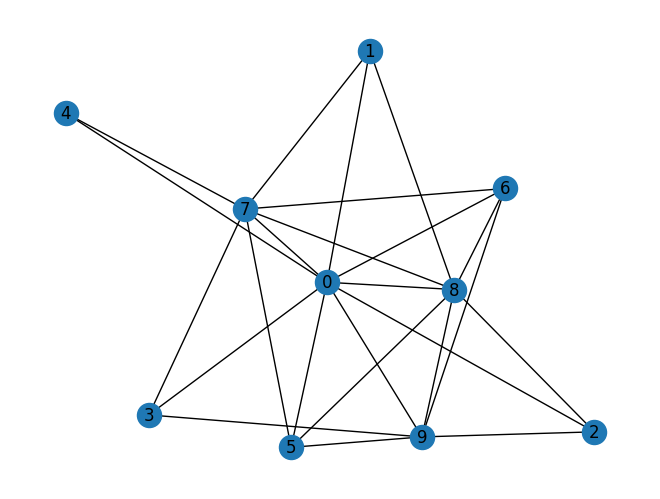

In [2]:
draw(graph, with_labels=True)

The graph above corresponds to the following operator.

In [3]:
from qopt_best_practices.utils import build_max_cut_paulis
from qiskit.quantum_info import SparsePauliOp

local_correlators = build_max_cut_paulis(graph)
cost_operator = SparsePauliOp.from_list(local_correlators)
print(cost_operator)

SparsePauliOp(['IIIIIIIIZZ', 'IIIIIIIZIZ', 'IIIIIIZIIZ', 'IIIIIZIIIZ', 'IIIIZIIIIZ', 'IIIZIIIIIZ', 'IIZIIIIIIZ', 'IZIIIIIIIZ', 'ZIIIIIIIIZ', 'IIZIIIIIZI', 'IZIIIIIIZI', 'IZIIIIIZII', 'ZIIIIIIZII', 'IIZIIIZIII', 'ZIIIIIZIII', 'IIZIIZIIII', 'IIZIZIIIII', 'IZIIZIIIII', 'ZIIIZIIIII', 'IIZZIIIIII', 'IZIZIIIIII', 'ZIIZIIIIII', 'IZZIIIIIII', 'ZZIIIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [4]:
# import json

# graph_file = "data/graph_2layers_0seed.json"
# data = json.load(open(graph_file, "r"))

# local_correlators = data["paulis"]
# print(local_correlators)
# cost_operator = SparsePauliOp.from_list(local_correlators)

This operator maps to a 10 qubit QAOA circuit:

In [5]:
num_qubits = cost_operator.num_qubits
print(num_qubits)

10


And we'll fix the number of QAOA layers to 2 for both workflows:

In [6]:
qaoa_layers = 3

We can design a fake backend with the same basis gates and connectivity as "ibm_torino" but smaller number of qubits that will allow us to perform a statevector simulation:

In [7]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler import CouplingMap

cmap = CouplingMap.from_heavy_hex(distance=3)
print(cmap.size())
backend = GenericBackendV2(num_qubits = 19, coupling_map = cmap, basis_gates = ["x", "sx", "cz", "id", "rz"], seed=0)

19


Now, let's look at a naive workflow using exclusively transpilation defaults:

## Naive QAOA Workflow

Build QAOA circuit/ansatz:

In [8]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import QAOAAnsatz
from qiskit.circuit import ParameterVector

# Initial state = equal superposition
initial_state = QuantumCircuit(num_qubits)
initial_state.h(range(num_qubits))

# Mixer operator = rx rotations
betas = ParameterVector("β", qaoa_layers)
mixer_operator = QuantumCircuit(num_qubits)
mixer_operator.rx(-2*betas[0], range(num_qubits))

# Use off-the-shelf qiskit QAOAAnsatz
qaoa_ansatz = QAOAAnsatz(
    cost_operator,
    initial_state = initial_state,
    mixer_operator = mixer_operator,
    reps = qaoa_layers,
)
qaoa_ansatz.measure_all()

Let's inspect the default pass manager for optimization level 3:

In [9]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

naive_pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

The pass contains the following stages:

In [10]:
print(naive_pm.expanded_stages)

('pre_init', 'init', 'post_init', 'pre_layout', 'layout', 'post_layout', 'pre_routing', 'routing', 'post_routing', 'pre_translation', 'translation', 'post_translation', 'pre_optimization', 'optimization', 'post_optimization', 'pre_scheduling', 'scheduling', 'post_scheduling')


In [11]:
# naive_pm.draw()

And the following passes per stage:

In [12]:
print("init")
for task in naive_pm.init._tasks:
    print(task)

print("----")
print("layout")
for task in naive_pm.layout._tasks:
    print(task)

print("----")
print("routing")
for task in naive_pm.routing._tasks:
    print(task)

print("----")
print("translation")
for task in naive_pm.translation._tasks:
    print(task)

print("----")
print("optimization")
for task in naive_pm.optimization._tasks:
    print(task)

print("----")
print("scheduling")
for task in naive_pm.scheduling._tasks:
    print(task)

init
----
layout
----
routing
----
translation
[<qiskit.transpiler.passes.synthesis.unitary_synthesis.UnitarySynthesis object at 0x147dcf550>, <qiskit.transpiler.passes.synthesis.high_level_synthesis.HighLevelSynthesis object at 0x147dcf6a0>, <qiskit.transpiler.passes.basis.basis_translator.BasisTranslator object at 0x147df10a0>]
----
optimization
[<qiskit.transpiler.passes.analysis.depth.Depth object at 0x147df4190>, <qiskit.transpiler.passes.analysis.size.Size object at 0x147df4220>, <qiskit.transpiler.passes.utils.minimum_point.MinimumPoint object at 0x147df42b0>]
----
scheduling


Let's use it to transpile the circuit:

In [13]:
def callback_func(**kwargs):
    pass_ = kwargs['pass_']
    print(pass_)

In [14]:
import time
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

naive_pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
t0 = time.time()
naively_transpiled_qaoa = naive_pm.run(qaoa_ansatz)
t1 = time.time()

In [15]:
print(f"transpilation time: {t1 - t0} (s)")

transpilation time: 1.808941125869751 (s)


In [16]:
naively_transpiled_qaoa.count_ops()

OrderedDict([('sx', 670),
             ('rz', 528),
             ('cz', 363),
             ('measure', 10),
             ('x', 1),
             ('barrier', 1)])

In [17]:
naively_transpiled_qaoa.depth()

767

Let's look at a domain-specific transpialation workflow and see how the transpilation time, total number of 2q gates and circuit depth compares to the default pipeline.

## Optimal QAOA Transpilation Workflow

The optimal QAOA workflow consists on the following steps:

1. We start off by only building the cost layer of the QAOA ansatz (this is the one that contains 2q gates)
2. We transpile the cost layer applying specific swap strategies as per [1,2]
3. We then build the QAOA circuit by alternating layers of transpiled cost + mixer
4. We translate the circuit to the hardware native gates and route it to the optimal qubit layout through backend evaluation as per [2]
   
### What's interesting about this workflow is that we can embed it fully in a custom staged pass manager. For this, we will design our own "QAOAPass" for step 3 of the workflow, and use passes already available in Qiskit to perform steps 2 and 4. 

### 1. Build cost layer

In [18]:
# We are taking advantage of the QAOAAnsatz class to build the cost layer, 
# note that we are giving it dummy initial state and mixer circuits.

dummy_initial_state = QuantumCircuit(num_qubits)  # the real initial state is defined later
dummy_mixer_operator = QuantumCircuit(num_qubits)  # the real mixer is defined later

cost_layer = QAOAAnsatz(
    cost_operator,
    reps=1,
    initial_state=dummy_initial_state,
    mixer_operator=dummy_mixer_operator,
    name="QAOA cost block",
)

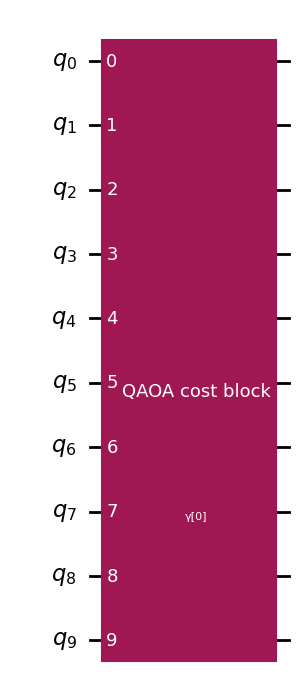

In [19]:
cost_layer.draw("mpl", fold=-1)

If we look inside the block we'll see a succession of pauli evolution gates that represent the problem hamiltonian:

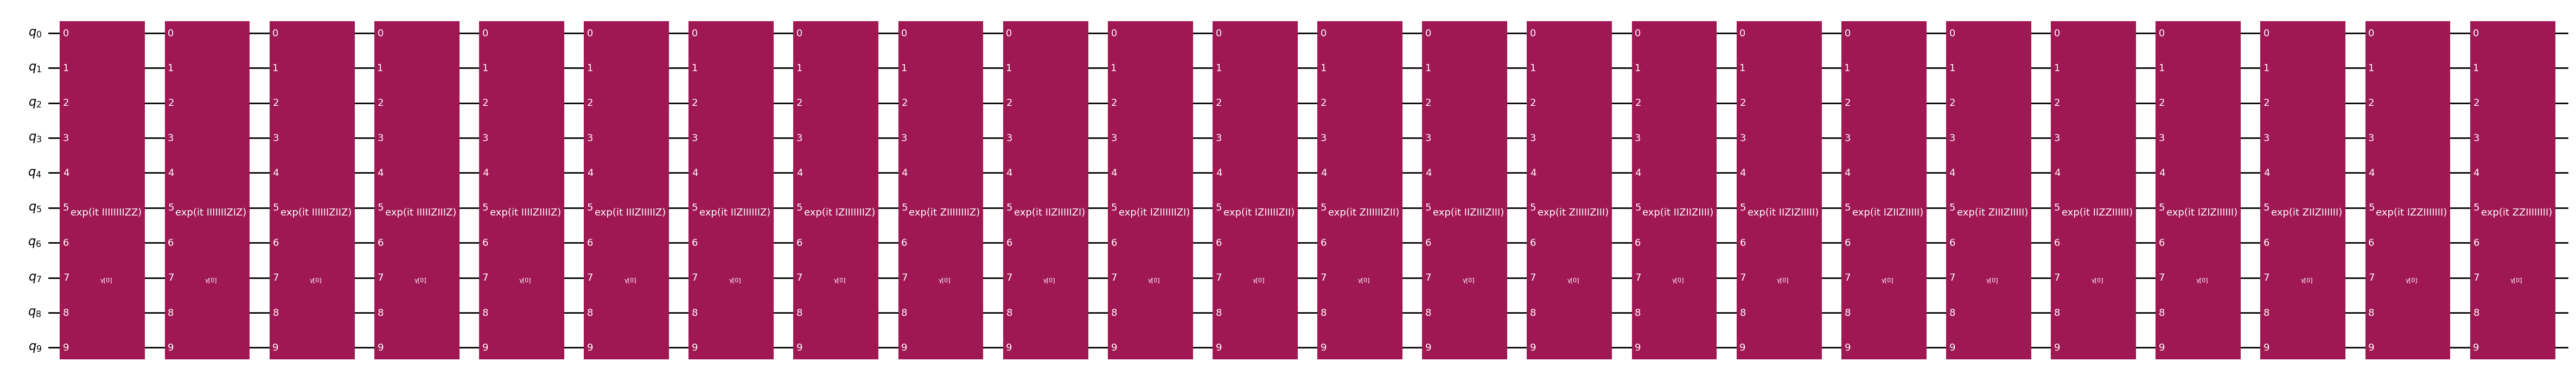

In [20]:
cost_layer.decompose(reps=2).draw("mpl", fold=-1)

### 2. Design pass manager for cost layer transpilation

The cost layer transpilation stage will apply the swap strategies from [1,2] to optimally route the cost layer circuit into the connectivity of our backend. This collection of passes will insert swap gates to fit the circuit to the chip connectivity in a way that will allow to maximally cancel CNOT gates and reduce the total circuit depth.

Note that we are routing the circuit into a `line`, which proves to be optimal in most QAOA cases. To make sure that the line fits into our chip, we use the `BackendEvaluator` utility before committing to the swap strategy:

In [21]:
from qopt_best_practices.qubit_selection import BackendEvaluator

# The backend evaluator finds the line of qubits with the best fidelity to map the circuit to
path_finder = BackendEvaluator(backend)
path, fidelity, num_subsets = path_finder.evaluate(num_qubits)
print(path, fidelity)

[2, 14, 1, 13, 0, 9, 3, 15, 11, 17] 0.9819974970192988


The collection of passes defined below will be embedded into the "pre_init" stage of our `StagedPassManager`.

In [22]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    BasisTranslator,
    UnrollCustomDefinitions,
    CommutativeCancellation,
    Decompose,
    CXCancellation,
    HighLevelSynthesis,
    InverseCancellation
)

from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import (
    SwapStrategy,
    FindCommutingPauliEvolutions,
    Commuting2qGateRouter,
)
from qiskit.circuit.library.standard_gates.equivalence_library import _sel
from qiskit.circuit.library import CXGate

In [23]:
# 1. choose swap strategy (in this case -> line)
swap_strategy = SwapStrategy.from_line([i for i in range(num_qubits)])
edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(num_qubits)}

# 2. define pass manager for cost layer
pre_init = PassManager(
            [HighLevelSynthesis(basis_gates=['PauliEvolution']),
             FindCommutingPauliEvolutions(),
             Commuting2qGateRouter(
                    swap_strategy,
                    edge_coloring,
                ),
             HighLevelSynthesis(basis_gates=["x", "cx", "sx", "rz", "id"]),
             InverseCancellation(gates_to_cancel=[CXGate()]),
            ]
)

We can run this pass manager independently to confirm that it performs the desired transformations:

OrderedDict([('cx', 48), ('rz', 24)])


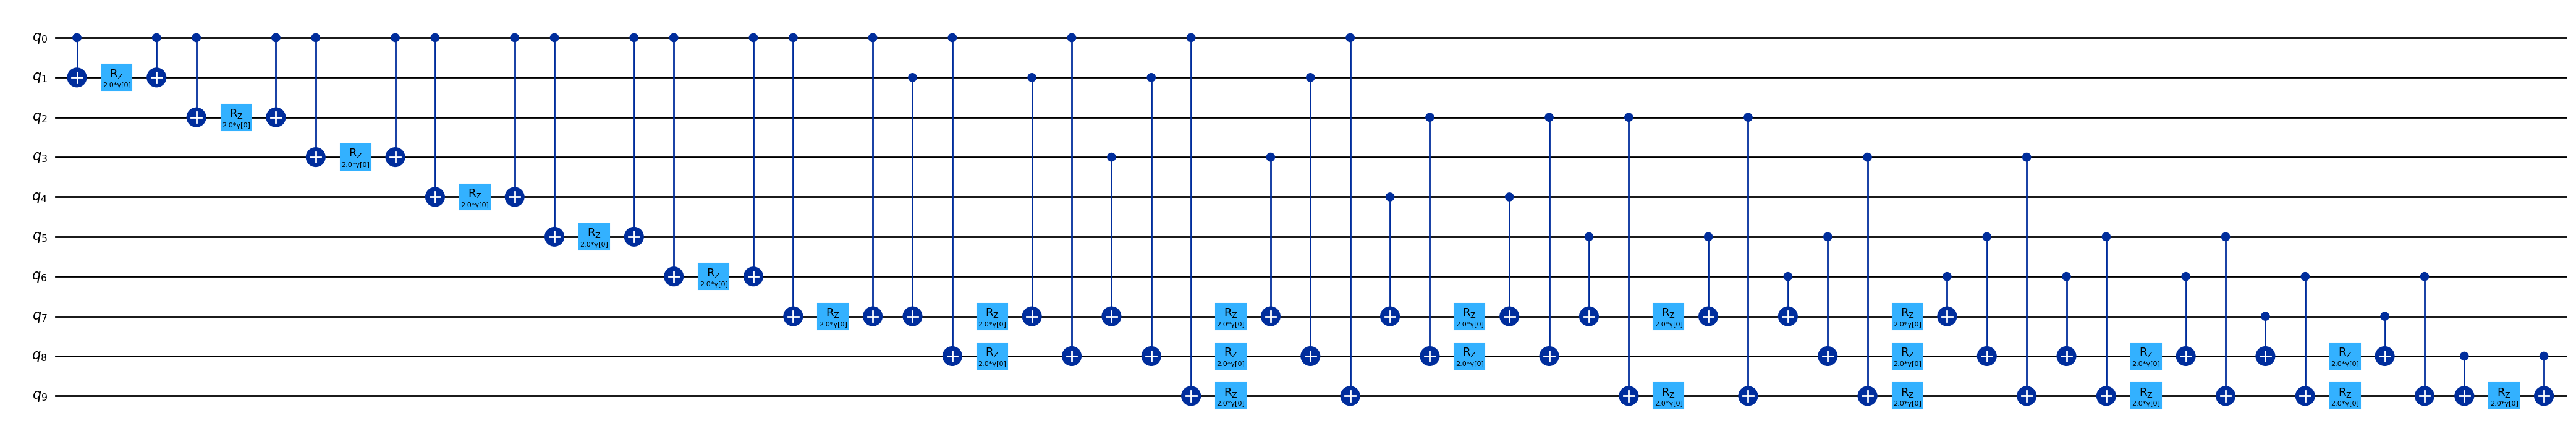

In [24]:
# Before:
print(cost_layer.decompose(reps=4).count_ops())
cost_layer.decompose(reps=4).draw("mpl", fold=-1)

In [25]:
tmp = pre_init.run(cost_layer)

OrderedDict([('cx', 114), ('rz', 24)])


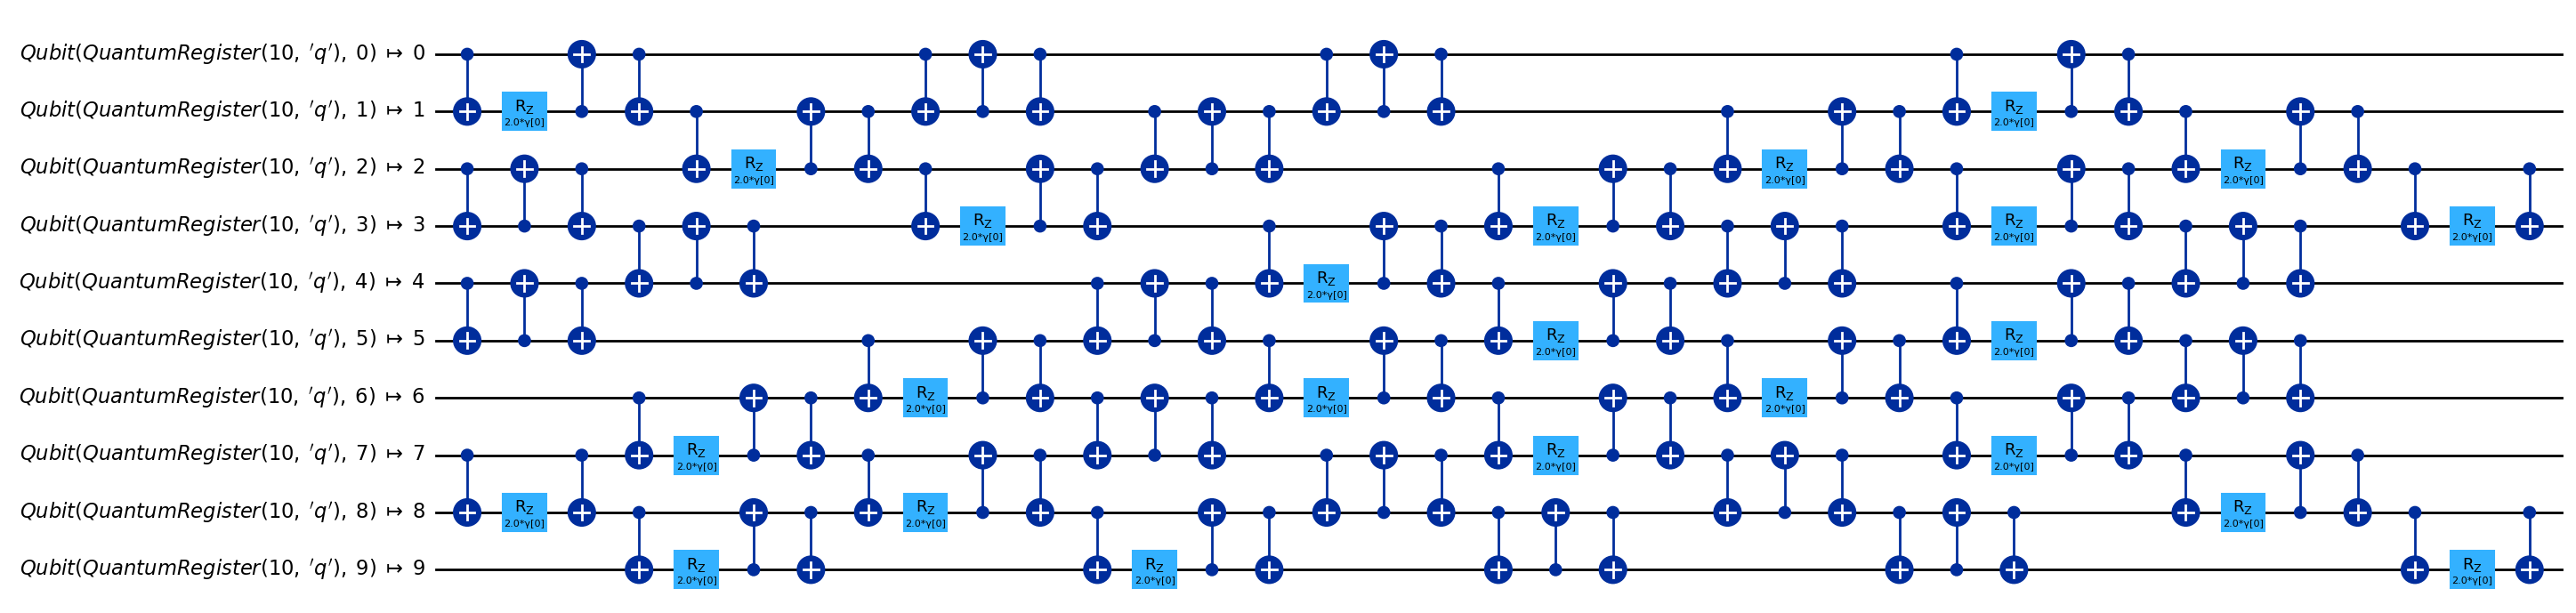

In [26]:
# After:
print(tmp.count_ops())
tmp.draw('mpl', fold=-1)

### 3. Build QAOA Ansatz

We now need to design a way to embed our optimized cost layer circuit into the QAOA ansatz, which consists of alternating layers of cost and mixer operators following an inital state. We can do it as part of a custom transformation pass that can be initialized with the desired cost layer, mixer layer, number of total layers and number of qubits. This pass will be placed at the "init" stage, after the pre_init pass has routed the cost layer.

In [27]:
from qiskit.transpiler.basepasses import TransformationPass
from qiskit.converters import circuit_to_dag, dag_to_circuit

class QAOAPass(TransformationPass):

    def __init__(self, num_layers, num_qubits, init_state = None, mixer_layer = None):

        super().__init__()
        self.num_layers = num_layers
        self.num_qubits = num_qubits
        
        if init_state is None:
            # Add default initial state -> equal superposition
            self.init_state = QuantumCircuit(num_qubits)
            self.init_state.h(range(num_qubits))
        else: 
            self.init_state = init_state
        
        if mixer_layer is None:
            # Define default mixer layer
            self.mixer_layer = QuantumCircuit(num_qubits)
            self.mixer_layer.rx(-2*betas[0], range(num_qubits))
        else:
            self.mixer_layer = mixer_layer

    def run(self, cost_layer_dag):

        cost_layer = dag_to_circuit(cost_layer_dag)
        qaoa_circuit = QuantumCircuit(self.num_qubits, self.num_qubits)
        # Re-parametrize the circuit
        gammas = ParameterVector("γ", self.num_layers)
        betas = ParameterVector("β", self.num_layers)

        # Add initial state
        qaoa_circuit.compose(self.init_state, inplace = True)

        # iterate over number of qaoa layers
        # and alternate cost/reversed cost and mixer
        for layer in range(self.num_layers): 
        
            bind_dict = {cost_layer.parameters[0]: gammas[layer]}
            bound_cost_layer = cost_layer.assign_parameters(bind_dict)
            
            bind_dict = {self.mixer_layer.parameters[0]: betas[layer]}
            bound_mixer_layer = self.mixer_layer.assign_parameters(bind_dict)
        
            if layer % 2 == 0:
                # even layer -> append cost
                qaoa_circuit.compose(bound_cost_layer, range(self.num_qubits), inplace=True)
            else:
                # odd layer -> append reversed cost
                qaoa_circuit.compose(bound_cost_layer.reverse_ops(), range(self.num_qubits), inplace=True)
        
            # the mixer layer is not reversed
            qaoa_circuit.compose(bound_mixer_layer, range(self.num_qubits), inplace=True)
        

        if self.num_layers % 2 == 1:
            # iterate over layout permutations to recover measurements
            if self.property_set["virtual_permutation_layout"]:
                for cidx, qidx in self.property_set["virtual_permutation_layout"].get_physical_bits().items():
                    qaoa_circuit.measure(qidx, cidx)
            else:
                print("layout not found, assigining trivial layout")
                for idx in range(self.num_qubits):
                    qaoa_circuit.measure(idx, idx)
        else:
            for idx in range(self.num_qubits):
                qaoa_circuit.measure(idx, idx)
    
        return circuit_to_dag(qaoa_circuit)
        

Once again, let's check that this custom pass runs and builds a QAOA circuit with 3 layers:

In [28]:
init = PassManager([QAOAPass(num_layers=3, num_qubits=10)])

layout not found, assigining trivial layout


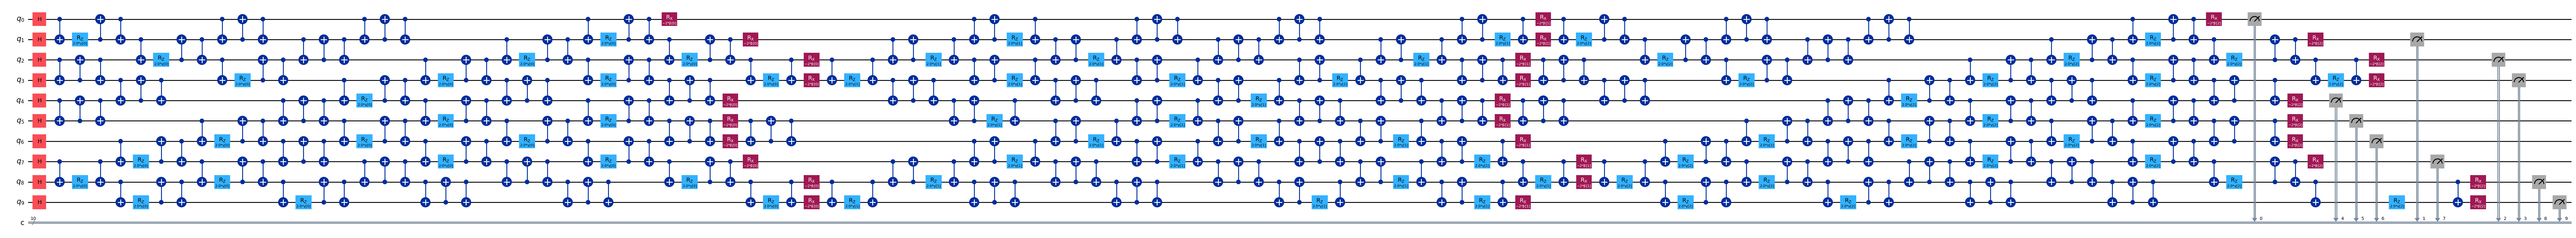

In [29]:
tmp_out = init.run(tmp)
tmp_out.count_ops()
tmp_out.draw('mpl', fold=-1)

### 4. Complete the pipeline

Now that we can build our optimized QAOA ansatz, we need to fill out the remaining stages of the pipeline. We can use as a reference the output of the preset pass manager and just replace the init, pre-init and post-init stages with our custom pass managers. We will have to define a "post_init" step that takes care of the basis translation part to match the expected output in the default pipeline.

In [30]:
from qiskit.transpiler import Layout

# We use the obtained path to define the initial layout
initial_layout = Layout.from_intlist(path, cost_layer.qregs[0])

In [31]:
# The post init step unrolls the gates in the ansatz to the backend basis gates
post_init = PassManager(
    [
        UnrollCustomDefinitions(_sel, basis_gates=backend.operation_names, min_qubits=3),
        BasisTranslator(_sel, target_basis=backend.operation_names, min_qubits=3),
    ]
)

In [32]:
staged_pm = generate_preset_pass_manager(3, backend, initial_layout=initial_layout)
staged_pm.pre_init = pre_init
staged_pm.init = init
staged_pm.post_init = post_init
# staged_pm.routing = None

In [33]:
print("pre_init")
for task in staged_pm.pre_init._tasks:
    print(task)
    
print("----")
print("init")
for task in staged_pm.init._tasks:
    print(task)

print("----")
print("post_init")
for task in staged_pm.post_init._tasks:
    print(task)
    
print("----")
print("layout")
for task in staged_pm.layout._tasks:
    print(task)

print("----")
print("optimization")
for task in staged_pm.optimization._tasks:
    print(task)

print("----")
print("routing")
for task in staged_pm.routing._tasks:
    print(task)

pre_init
[<qiskit.transpiler.passes.synthesis.high_level_synthesis.HighLevelSynthesis object at 0x149b856a0>, <qiskit.transpiler.passes.routing.commuting_2q_gate_routing.pauli_2q_evolution_commutation.FindCommutingPauliEvolutions object at 0x149befa90>, <qiskit.transpiler.passes.routing.commuting_2q_gate_routing.commuting_2q_gate_router.Commuting2qGateRouter object at 0x149bef940>, <qiskit.transpiler.passes.synthesis.high_level_synthesis.HighLevelSynthesis object at 0x149bef3a0>, <qiskit.transpiler.passes.optimization.inverse_cancellation.InverseCancellation object at 0x149bcf070>]
----
init
----
post_init
[<qiskit.transpiler.passes.basis.unroll_custom_definitions.UnrollCustomDefinitions object at 0x14980d130>, <qiskit.transpiler.passes.basis.basis_translator.BasisTranslator object at 0x14980dfd0>]
----
layout
----
optimization
[<qiskit.transpiler.passes.analysis.depth.Depth object at 0x148079f10>, <qiskit.transpiler.passes.analysis.size.Size object at 0x1480794f0>, <qiskit.transpiler.

### 5. Run the StagedPassManager

In [34]:
t0_opt = time.time()
optimally_transpiled_qaoa = staged_pm.run(cost_layer)
t1_opt = time.time()

## Comparison between naive and optimal

In [35]:
naive_count = naively_transpiled_qaoa.count_ops().get("cz", 0)
optimal_count = optimally_transpiled_qaoa.count_ops().get("cz", 0)

print(f"2q gate count for naive circuit = {naive_count}")
print(f"2q gate count for optimal circuit = {optimal_count}")

2q gate count for naive circuit = 363
2q gate count for optimal circuit = 342


In [36]:
naive_2q_depth = naively_transpiled_qaoa.depth(filter_function=lambda x: x.operation.name == "cz")
optimal_2q_depth = optimally_transpiled_qaoa.depth(filter_function=lambda x: x.operation.name == "cz")

print(f"2q depth for naive circuit = {naive_2q_depth}")
print(f"2q depth for optimal circuit = {optimal_2q_depth}")

2q depth for naive circuit = 243
2q depth for optimal circuit = 84


In [37]:
naive_depth = naively_transpiled_qaoa.depth()
optimal_depth = optimally_transpiled_qaoa.depth()

print(f"total depth for naive circuit = {naive_depth}")
print(f"total depth for optimal circuit = {optimal_depth}")

total depth for naive circuit = 767
total depth for optimal circuit = 322


In [38]:
time_naive = t1 - t0
time_optimal = (t1_opt - t0_opt)

print(f"total time for naive transpilation = {time_naive} (s)")
print(f"total time for optimal transpilation = {time_optimal} (s)")

total time for naive transpilation = 1.808941125869751 (s)
total time for optimal transpilation = 1.670518159866333 (s)


In [39]:
# optimally_transpiled_qaoa.draw(fold=-1)

In [40]:
# naively_transpiled_qaoa.draw(fold=-1)

## Stripping down the pipeline

In [41]:
from qiskit.transpiler.passes import (
    FullAncillaAllocation,
    EnlargeWithAncilla,
    ApplyLayout,
    SetLayout,
)

# The post init step unrolls the gates in the ansatz to the backend basis gates
post_init = PassManager(
    [
        UnrollCustomDefinitions(_sel, basis_gates=backend.operation_names),
        BasisTranslator(_sel, target_basis=backend.operation_names),
    ]
)

# The layout step applies the previously computed layout and enlarges the circuit 
# with ancilla qubits to have the same number of physical qubits as the target
layout = PassManager(
    [
        SetLayout(initial_layout),
        FullAncillaAllocation(backend.target),
        EnlargeWithAncilla(),
        ApplyLayout(),
    ]
)

# The optimization step performs additional gate cancellations
optimization = PassManager(
    [
      CommutativeCancellation(target=backend.target)
    ]
)

from qiskit.transpiler import StagedPassManager
other_staged_pm = StagedPassManager(stages=["init", "layout", 'optimization'], pre_init=pre_init, init=init, post_init=post_init, layout=layout, optimization=optimization)

In [42]:
t0_opt = time.time()
optimally_transpiled_qaoa = other_staged_pm.run(cost_layer)
t1_opt = time.time()

In [43]:
naive_count = naively_transpiled_qaoa.count_ops().get("cz", 0)
optimal_count = optimally_transpiled_qaoa.count_ops().get("cz", 0)

print(f"2q gate count for naive circuit = {naive_count}")
print(f"2q gate count for optimal circuit = {optimal_count}")

2q gate count for naive circuit = 363
2q gate count for optimal circuit = 342


In [44]:
naive_2q_depth = naively_transpiled_qaoa.depth(filter_function=lambda x: x.operation.name == "cz")
optimal_2q_depth = optimally_transpiled_qaoa.depth(filter_function=lambda x: x.operation.name == "cz")

print(f"2q depth for naive circuit = {naive_2q_depth}")
print(f"2q depth for optimal circuit = {optimal_2q_depth}")

2q depth for naive circuit = 243
2q depth for optimal circuit = 84


In [45]:
naive_depth = naively_transpiled_qaoa.depth()
optimal_depth = optimally_transpiled_qaoa.depth()

print(f"total depth for naive circuit = {naive_depth}")
print(f"total depth for optimal circuit = {optimal_depth}")

total depth for naive circuit = 767
total depth for optimal circuit = 340


In [46]:
time_naive = t1 - t0
time_optimal = (t1_opt - t0_opt)

print(f"total time for naive transpilation = {time_naive} (s)")
print(f"total time for optimal transpilation = {time_optimal} (s)")

total time for naive transpilation = 1.808941125869751 (s)
total time for optimal transpilation = 0.90982985496521 (s)
